In [112]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
from DB.models import init_db, Circuit, Season, RacingWeekend, Driver, Session, SessionResult, Lap


## Collect data into df

In [113]:
def create_dataframe():
	# initialize db connection and session
	db_engine, db_session = init_db()

	# query data from the database
	query = db_session.query(
		RacingWeekend.year,
		RacingWeekend.round,
		Circuit.circuit_name,
		Driver.driver_name,
		Driver.driver_short,
		Lap.lap_num,
		Lap.lap_time,
		Lap.tyre,
		Lap.tyre_laps,
		Lap.pit,
		Session.session_type
	).join(RacingWeekend.circuit) \
	 .join(RacingWeekend.sessions) \
	 .join(Session.laps) \
	 .join(Lap.driver) \
	 .join(RacingWeekend.season) \
	 .all()

	# convert result to list of dicts
	data = []
	for row in query:
		data.append({
			'year': row.year,
			'round': row.round,
			'circuit_name': row.circuit_name,
			'driver_name': row.driver_name,
			'driver_short': row.driver_short,
			'lap_num': row.lap_num,
			'lap_time': row.lap_time,
			'tyre': row.tyre,
			'tyre_laps': row.tyre_laps,
			'pit': row.pit,
			'session_type': row.session_type
		})

	# create dataframe
	df = pd.DataFrame(data)


	return df

# create the dataframe and print it
df = create_dataframe()

print(df.columns.tolist())




['year', 'round', 'circuit_name', 'driver_name', 'driver_short', 'lap_num', 'lap_time', 'tyre', 'tyre_laps', 'pit', 'session_type']


### Calc tyre deg

So here i want to look at the practice sessions for a weekend, look at long runs for a car, then find out tyre deg

1. Average through last season (or maybe last x races) for each driver, if driver wasnt in last season, then average of all (or maybe same car in previous year?)
1. Look at practice and just try and get something from it, but not a lot of long runs
1. Just set an absolute value no matter what, maybe i just look into it now and set the value




In [114]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Assuming 'df' is the DataFrame containing all race data

driver_short = "NOR"
target_year = 2023
target_round = 3

# Filter for the target race and driver
df_driver_race = df[ (df['driver_short'] == driver_short) & (df['session_type'] == "Race") ]

# Filter for races before the target year and round
df_past_races_metadata = (
    df_driver_race[
        (df_driver_race['year'] < target_year) | 
        ((df_driver_race['year'] == target_year) & (df_driver_race['round'] < target_round))
    ]
    .drop_duplicates(subset=['year', 'round'])  # Ensure unique races
    .sort_values(['year', 'round'], ascending=[False, False])  # Sort by year and round
    .head(40)  # Get the last 10 races
)



# Get the year and round for the last 10 races
last_10_races = df_past_races_metadata[['year', 'round']]

# Filter the original DataFrame to include all laps for these races
df_past_races = df_driver_race.merge(last_10_races, on=['year', 'round'], how='inner')

# Reset the index for clean display
df_past_races = df_past_races.sort_values(['year', 'round', 'lap_num']).reset_index(drop=True)

# Initialize degradation data
degradation_data = {}

# Initialize PolynomialFeatures object for quadratic model
poly = PolynomialFeatures(degree=2)

# Loop through each tire type (assuming 1, 2, 3 are tire types)
for tire_type in [1, 2, 3]:
    # Filter for the specific tire type
    df_tire = df_past_races[df_past_races['tyre'] == tire_type]
    
    # Exclude safety car laps
    race_fastest_laps = df_tire.groupby(['year', 'round'])['lap_time'].min()
    df_tire['safety_car'] = df_tire.apply(
        lambda row: row['lap_time'] > 1.2 * race_fastest_laps[row['year'], row['round']],
        axis=1
    )
    df_tire = df_tire[~df_tire['safety_car']]

    # Identify stints (assume a new stint is defined by a tire change or pit stop)
    # Here, we're assuming a new stint when the tire lap count resets to 1 (after a pit stop)
    df_tire['stint'] = df_tire.groupby(['year', 'round'])['tyre_laps'].transform('min')  # Create stint identifiers
    
    # Store the polynomial coefficients for each stint
    stint_coefficients = []

    # Loop through each stint
    for stint, group in df_tire.groupby('stint'):
        X = group[['lap_num']].values  # Lap numbers for the current stint
        y = group['lap_time'].values  # Lap times for the current stint
        
        # Fit polynomial regression for the current stint
        X_poly = poly.fit_transform(X)  # Transform lap numbers to polynomial features
        model = LinearRegression().fit(X_poly, y)  # Fit the model
        
        # Extract coefficients for the quadratic model
        stint_coefficients.append(model.coef_)

    # Average the coefficients across all stints
    avg_coefficients = pd.DataFrame(stint_coefficients).mean(axis=0)
    
    # Store the average degradation model for this tire type
    degradation_data[tire_type] = avg_coefficients

    # Print the polynomial equation for the tire type
    print(f"Average Polynomial Equation for Tire Type {tire_type}:")
    print(f"y = {avg_coefficients[2]:.3f} * x^2 + {avg_coefficients[1]:.3f} * x + {model.intercept_:.3f}")
    print("\n")

# Output the average degradation for each tire type
print("Average Degradation Models for Tire Types:", degradation_data)


Average Polynomial Equation for Tire Type 1:
y = 0.022 * x^2 + -0.225 * x + 74.943


Average Polynomial Equation for Tire Type 2:
y = 0.005 * x^2 + -0.237 * x + 86.615


Average Polynomial Equation for Tire Type 3:
y = 0.001 * x^2 + -0.193 * x + 104.032


Average Degradation Models for Tire Types: {1: 0    0.000000
1   -0.225015
2    0.022139
dtype: float64, 2: 0    0.000000
1   -0.236997
2    0.005409
dtype: float64, 3: 0    0.000000
1   -0.193012
2    0.001093
dtype: float64}


/tmp/ipykernel_19424/3846262443.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tire['safety_car'] = df_tire.apply(
/tmp/ipykernel_19424/3846262443.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tire['safety_car'] = df_tire.apply(
/tmp/ipykernel_19424/3846262443.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

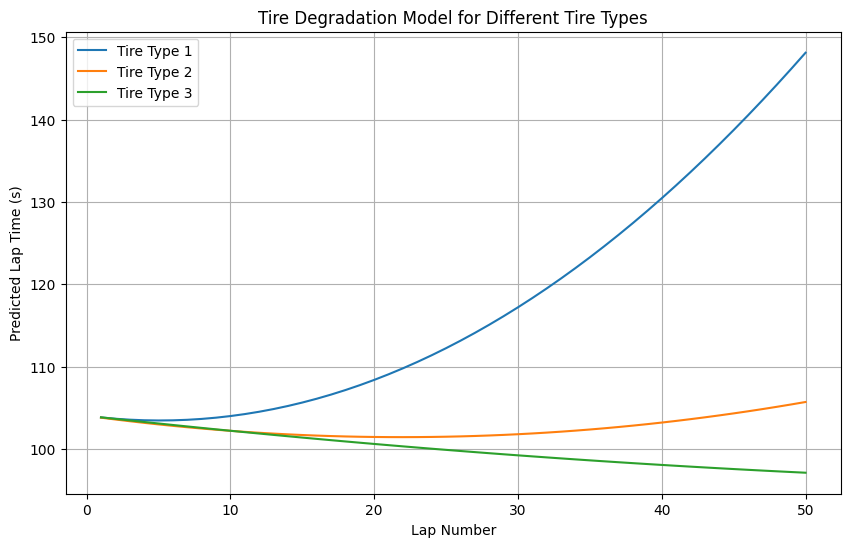

In [105]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the 'degradation_data' dictionary with average polynomial coefficients
# Each entry in 'degradation_data' contains the coefficients for a tire type (degree 2 polynomial)

# Define a range of lap numbers for plotting (e.g., lap 1 to lap 50)
lap_range = np.arange(1, 51)  # Adjust the range based on your race data

# Create a figure for plotting
plt.figure(figsize=(10, 6))

# Loop through each tire type and plot the polynomial equation
for tire_type, coefficients in degradation_data.items():
    # Extract coefficients for the quadratic equation (a * x^2 + b * x + c)
    a = coefficients[2]
    b = coefficients[1]
    c = model.intercept_  # Intercept is the same for all tire types as it's the last fitted model
    
    # Calculate predicted lap times using the polynomial equation
    lap_times = a * lap_range**2 + b * lap_range + c
    
    # Plot the polynomial curve
    plt.plot(lap_range, lap_times, label=f'Tire Type {tire_type}')

# Customize the plot
plt.title("Tire Degradation Model for Different Tire Types")
plt.xlabel("Lap Number")
plt.ylabel("Predicted Lap Time (s)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


/tmp/ipykernel_19424/2696867419.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tire_2['is_safety_car'] = df_tire_2.apply(


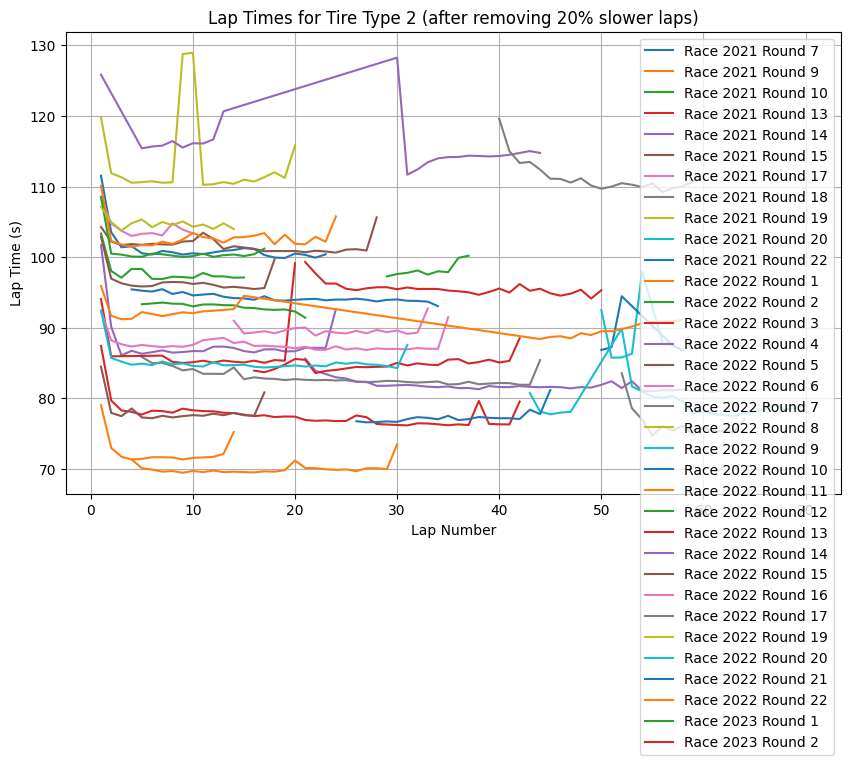

In [ ]:
import matplotlib.pyplot as plt

# Filter data for Tire Type 2
df_tire_2 = df_past_races[df_past_races['tyre'] == 2]

# Calculate the fastest lap time for each race
race_fastest_laps = df_tire_2.groupby(['year', 'round'])['lap_time'].min()

# Filter out laps that are more than 20% slower than the fastest lap
df_tire_2['is_safety_car'] = df_tire_2.apply(
    lambda row: row['lap_time'] > 1.2 * race_fastest_laps[row['year'], row['round']], axis=1
)
df_tire_2_filtered = df_tire_2[~df_tire_2['is_safety_car']]

# Plot raw lap times for Tire Type 2 after filtering out the 20% slower laps
plt.figure(figsize=(10, 6))
for (year, round), group in df_tire_2_filtered.groupby(['year', 'round']):
    plt.plot(group['lap_num'], group['lap_time'], label=f'Race {year} Round {round}')

plt.title("Lap Times for Tire Type 2 (after removing 20% slower laps)")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (s)")
plt.legend()
plt.grid(True)
plt.show()
